# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [5]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"),
                             input_pipe=None, rot_mult=4)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


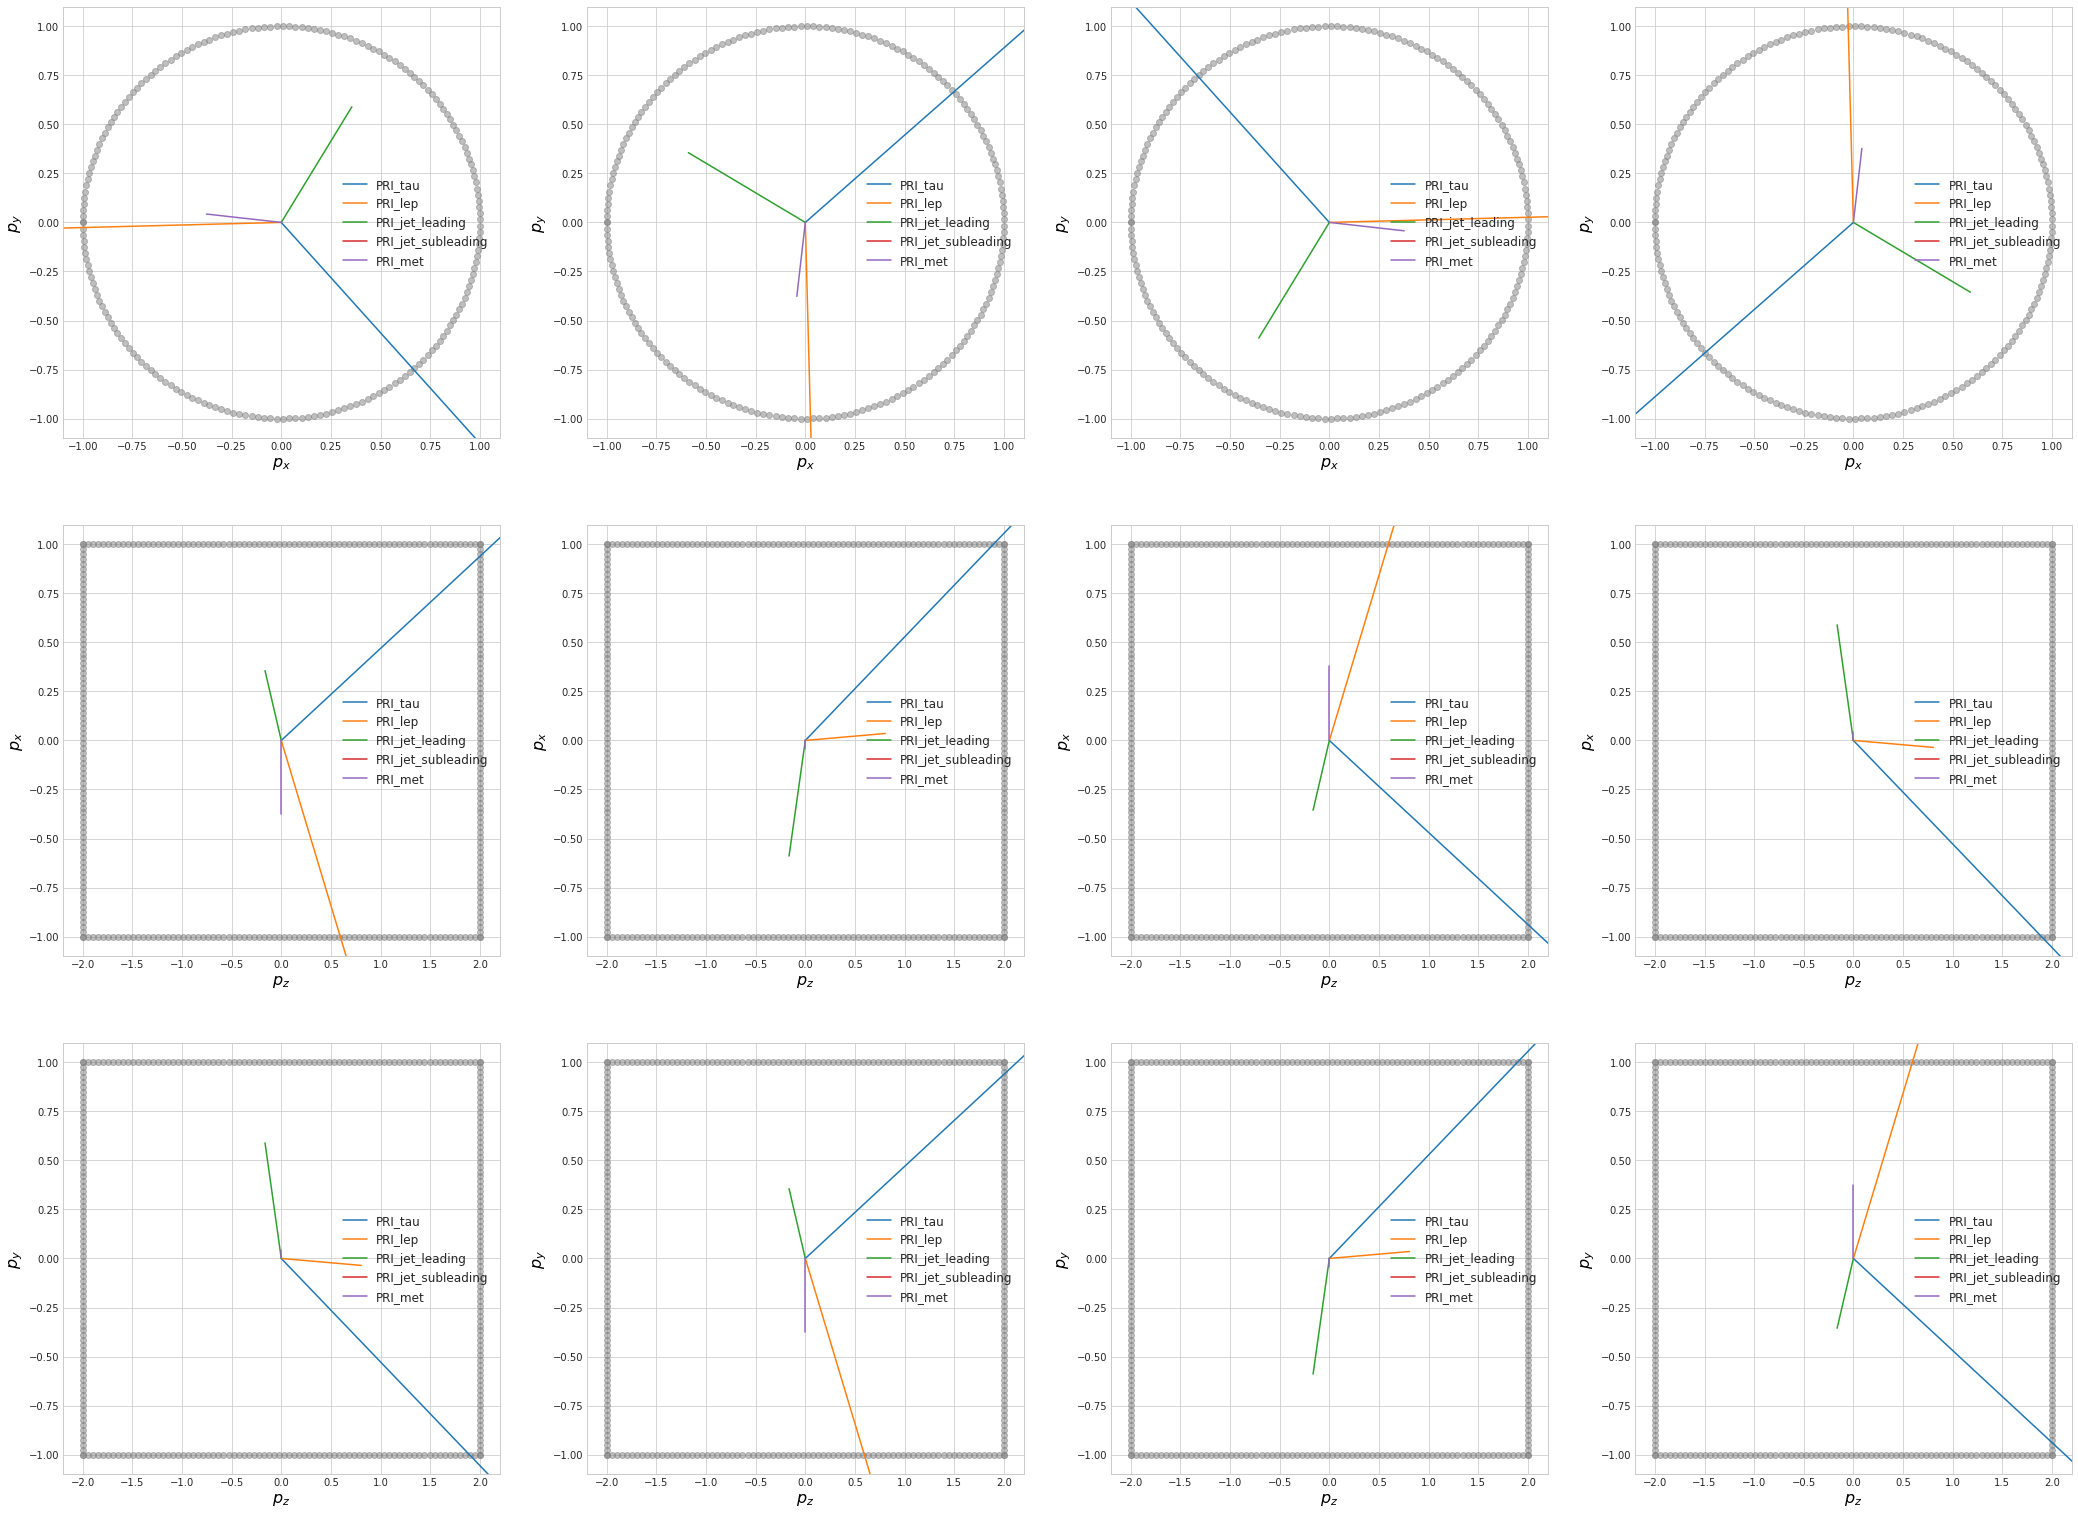

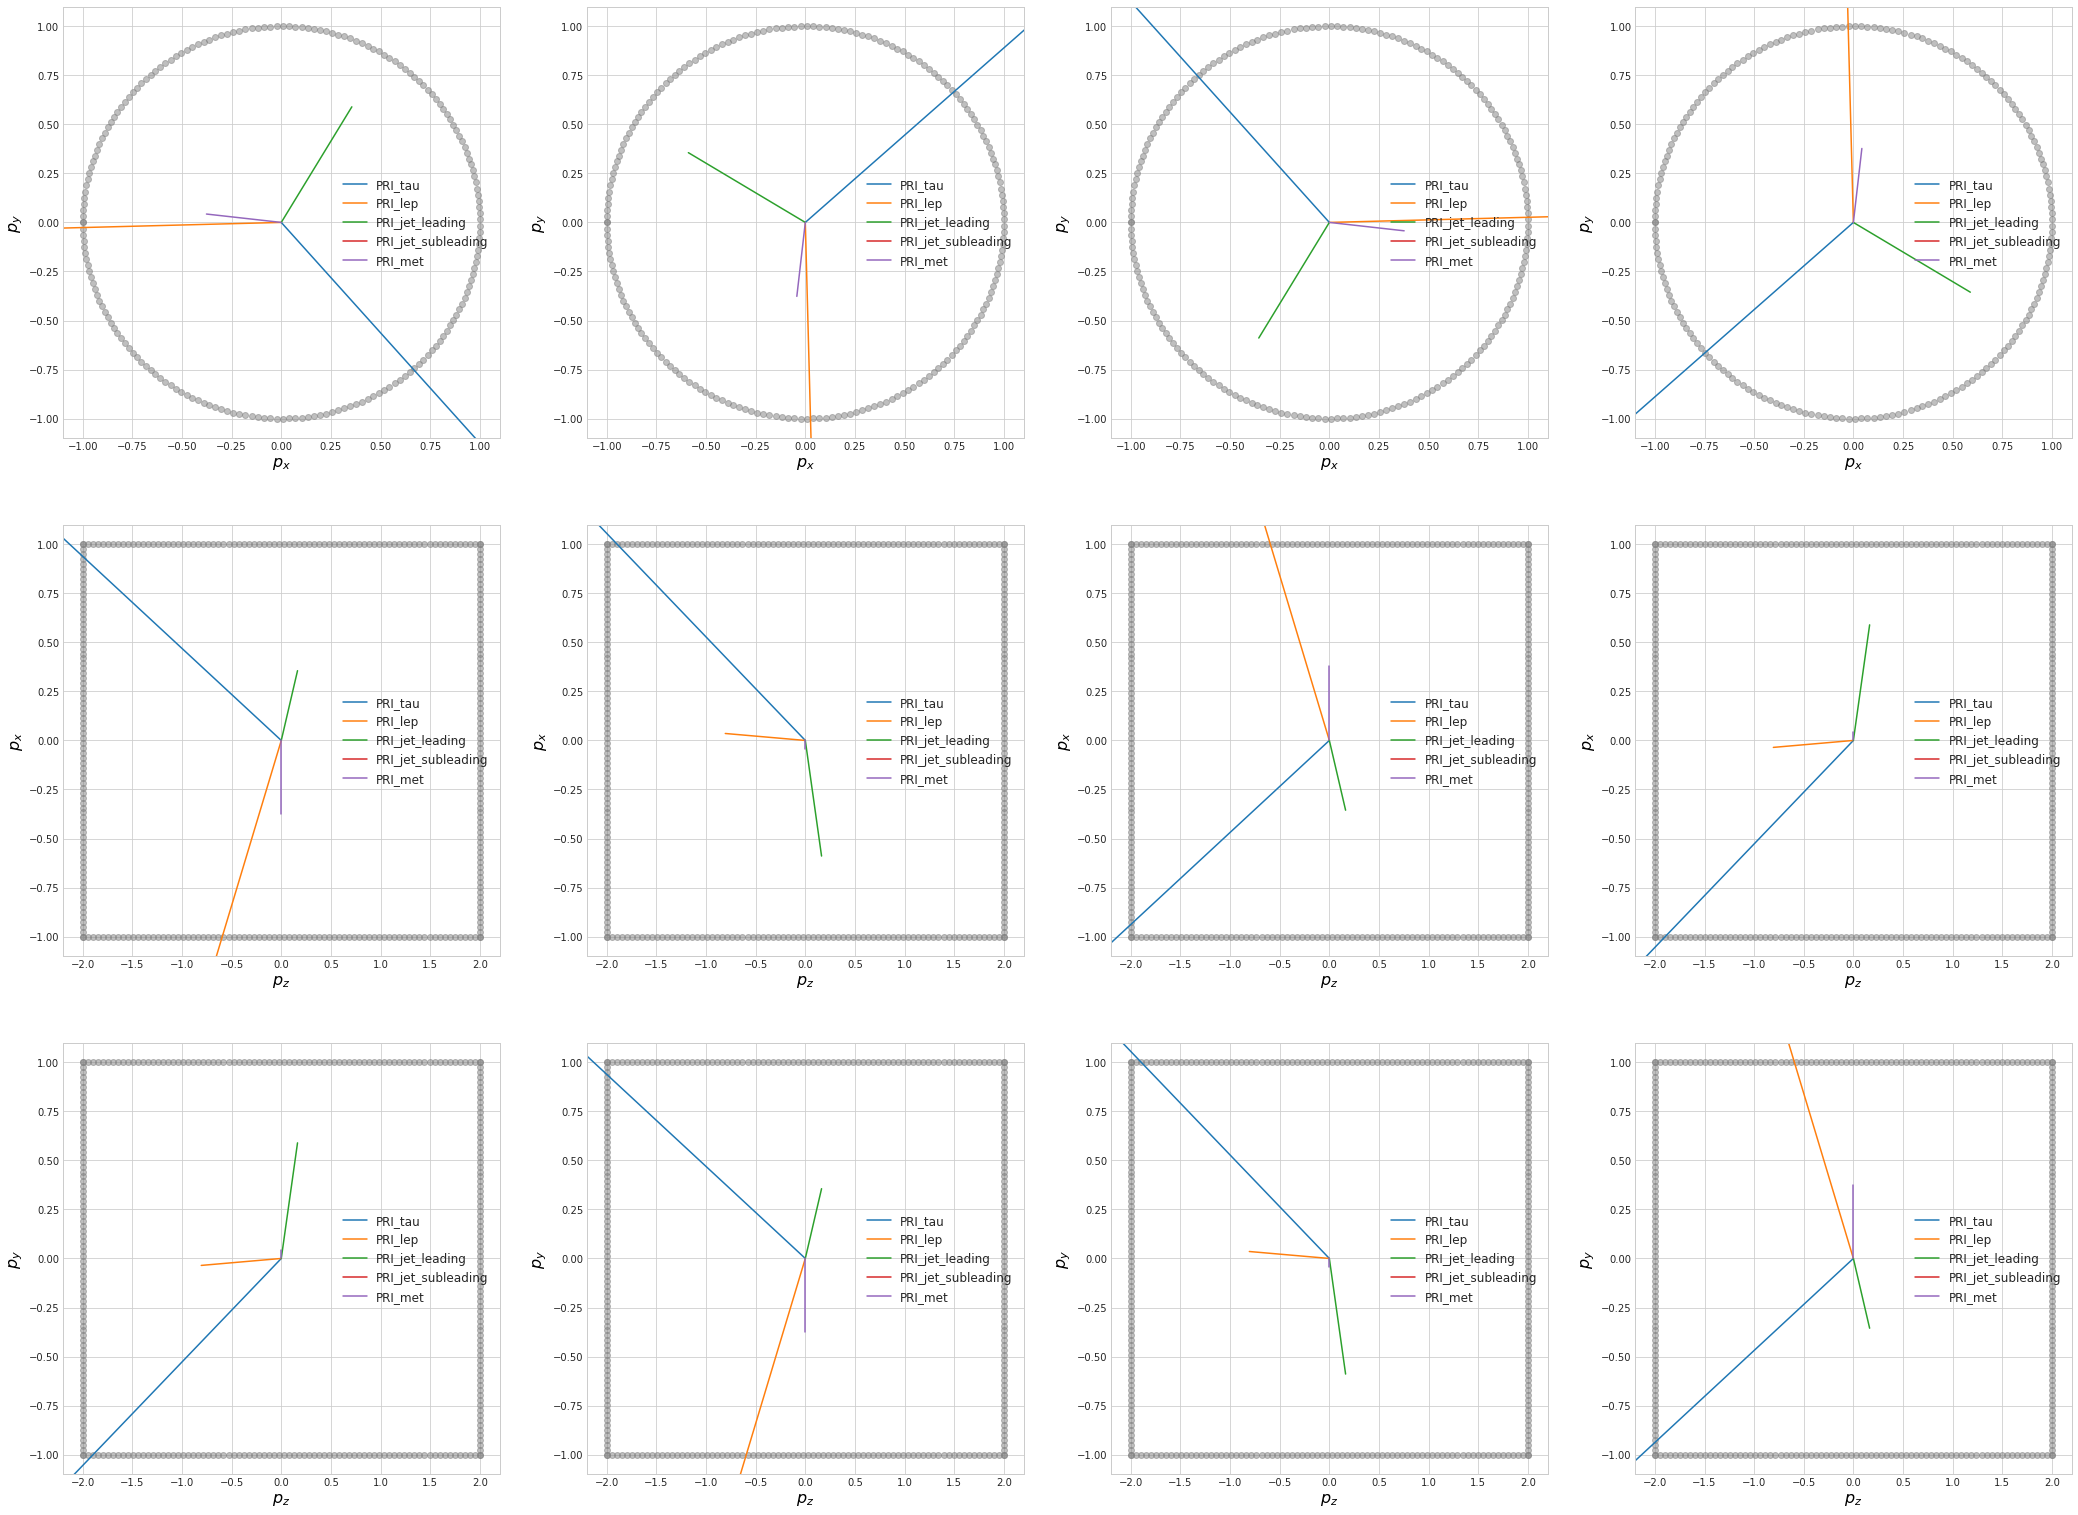

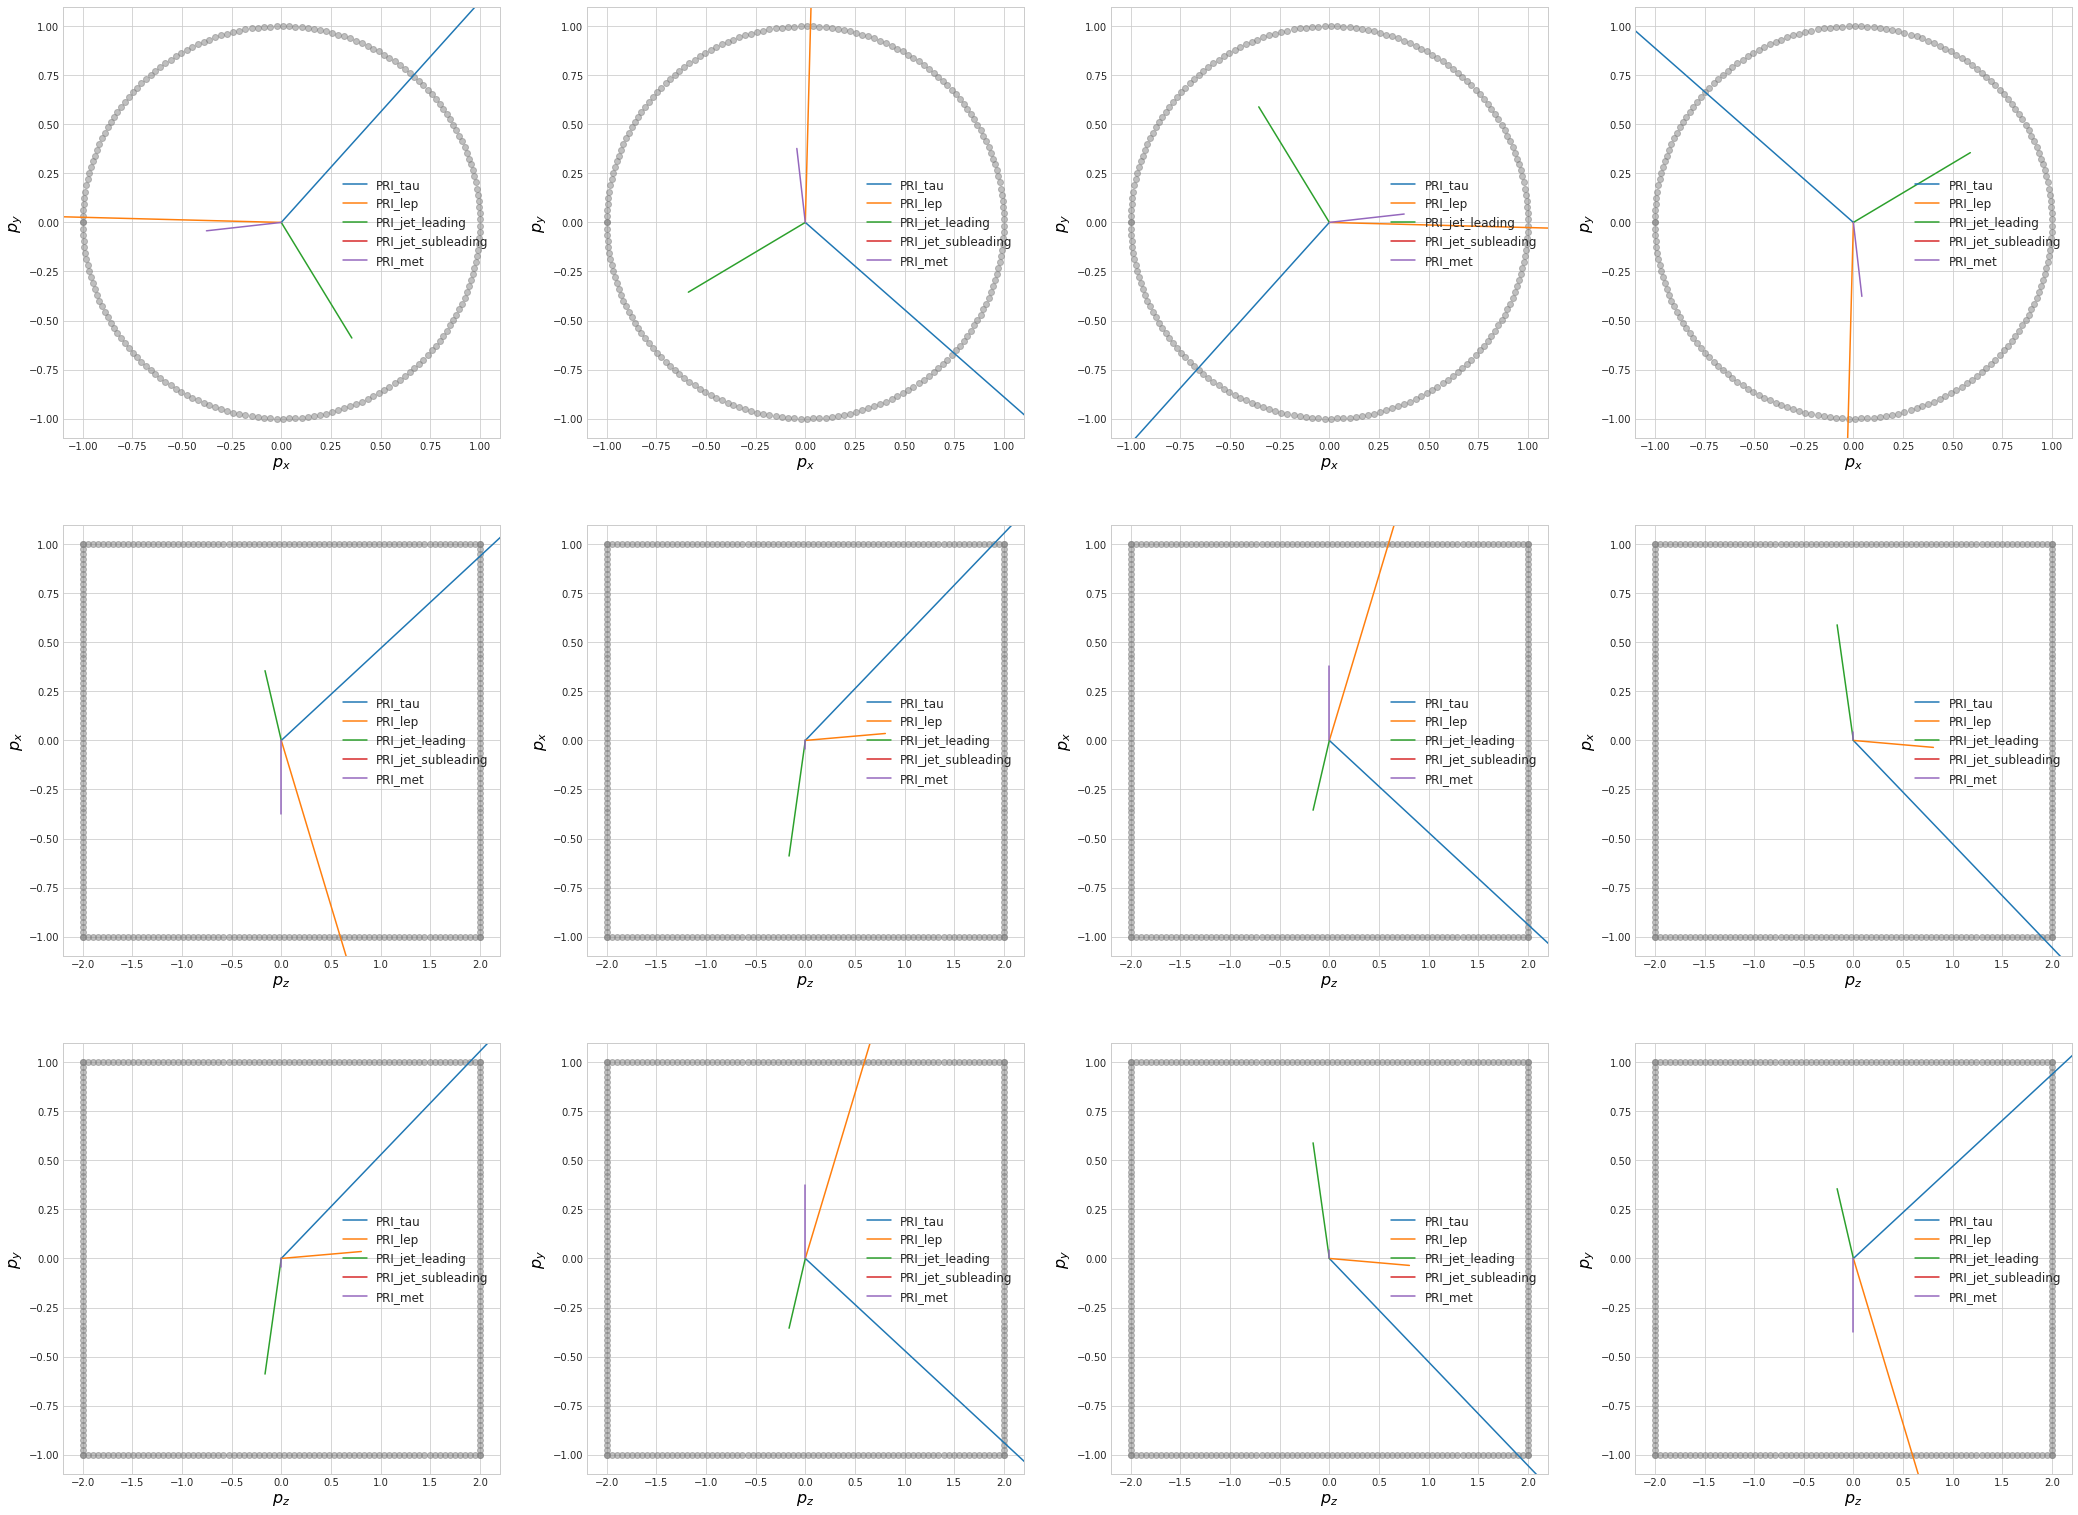

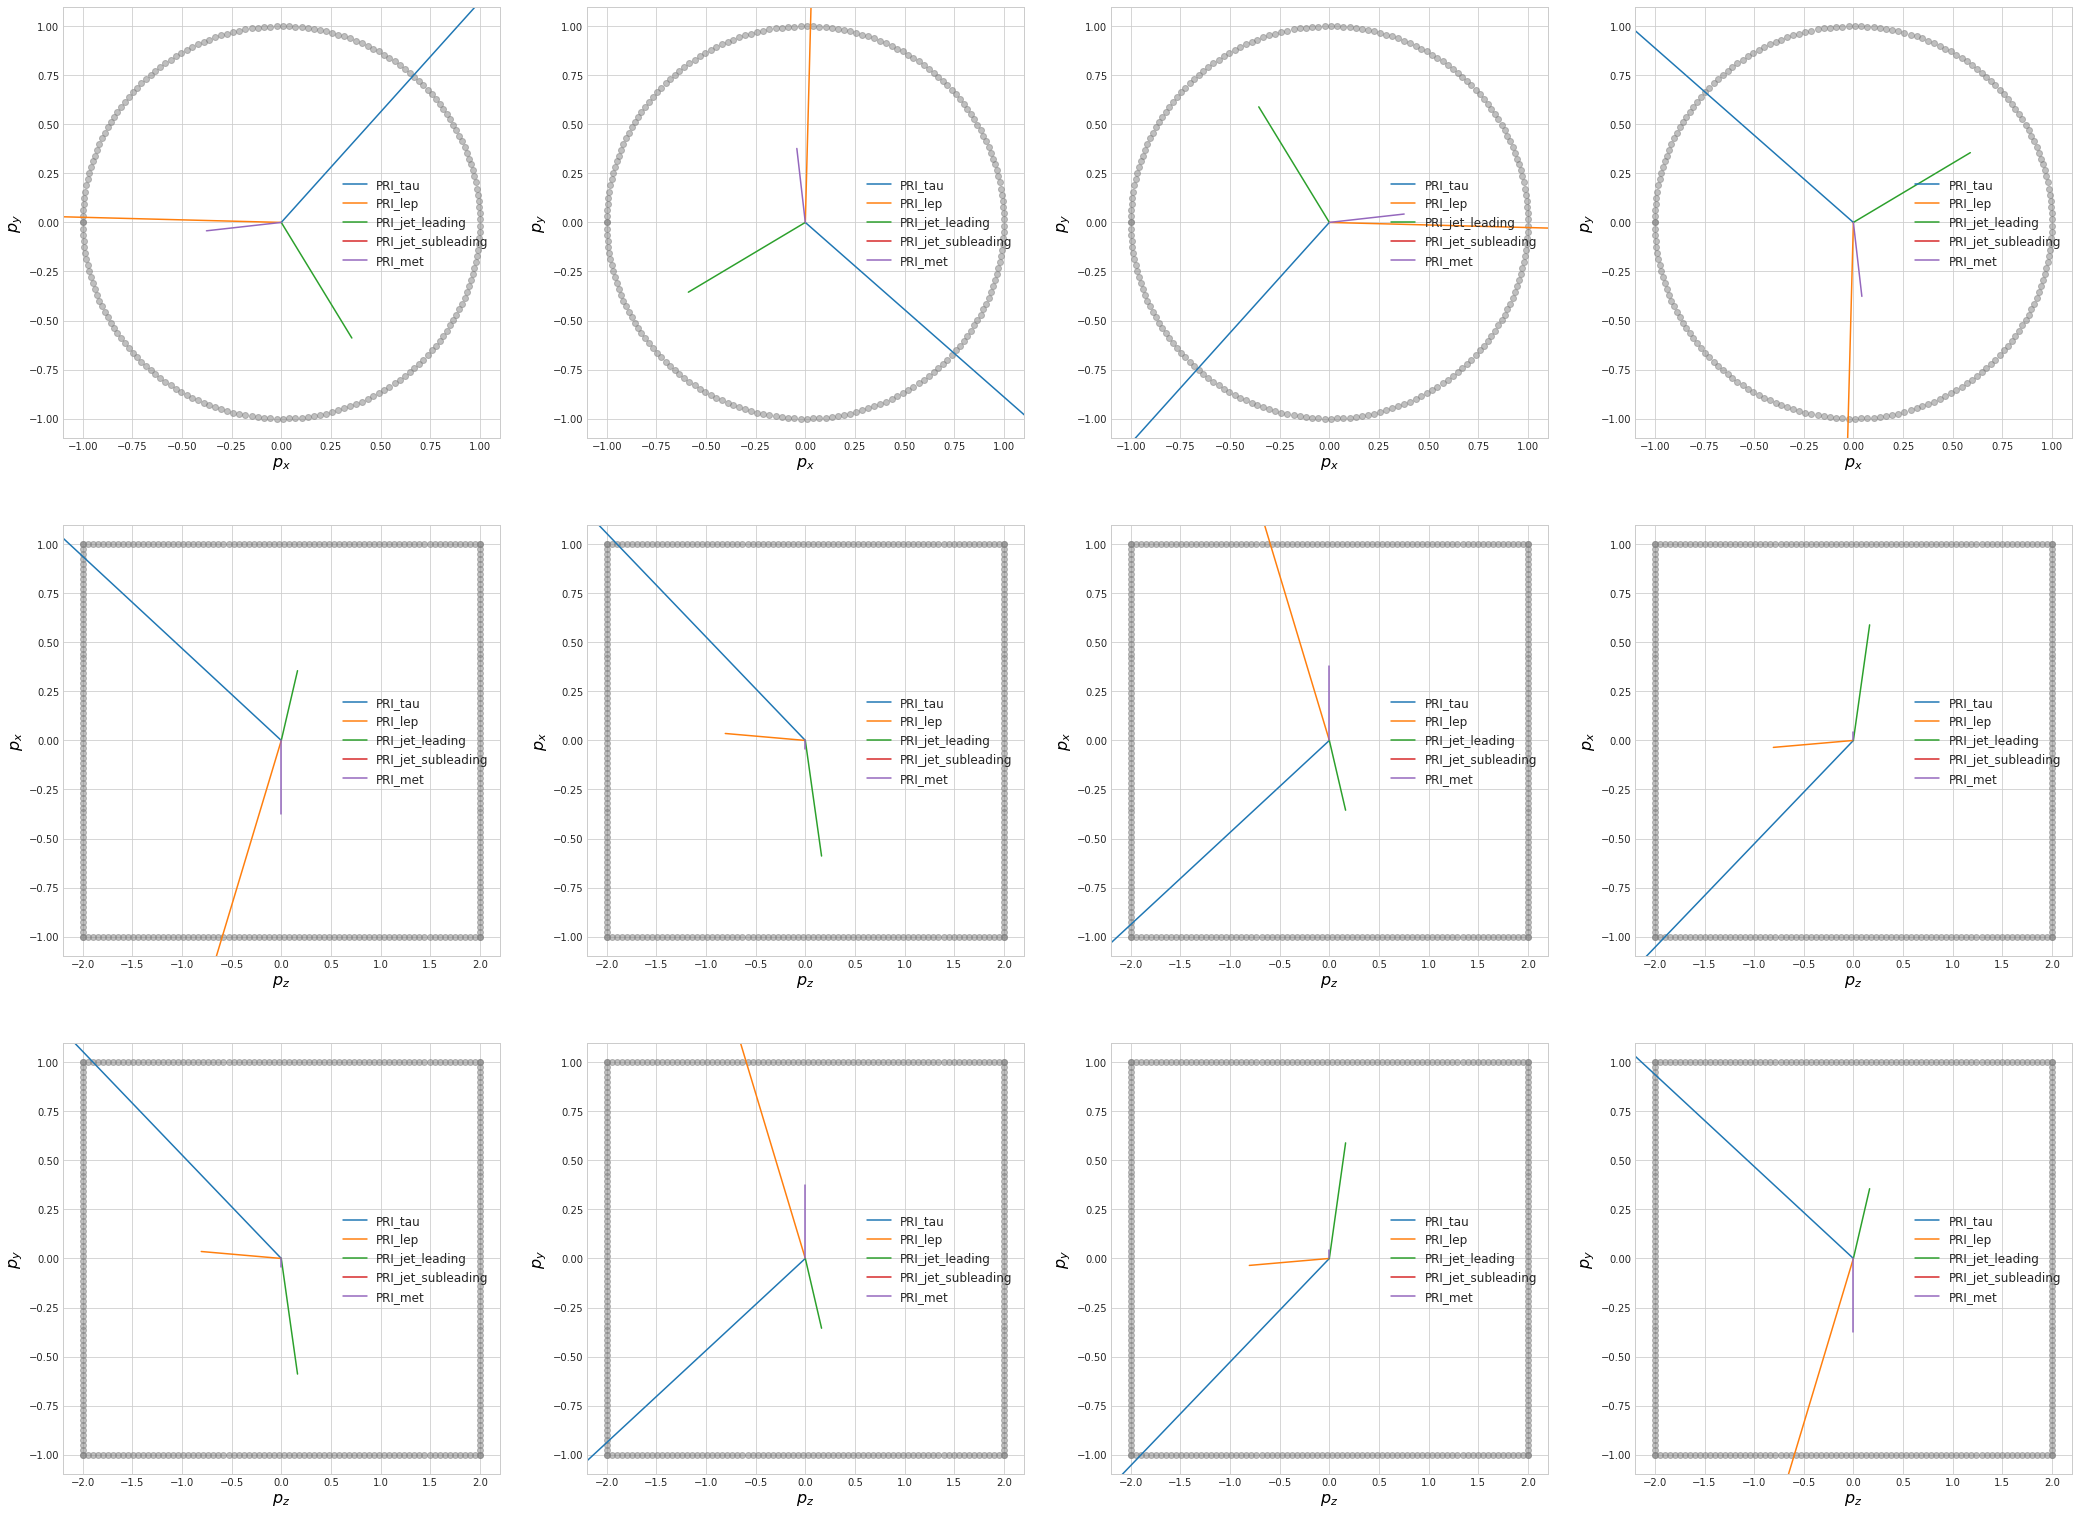

In [6]:
id=3
aug_ranges = [range(4), range(4,8), range(8,12), range(12,16)]
for aug_range in aug_ranges:
    comp_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 18.235s 


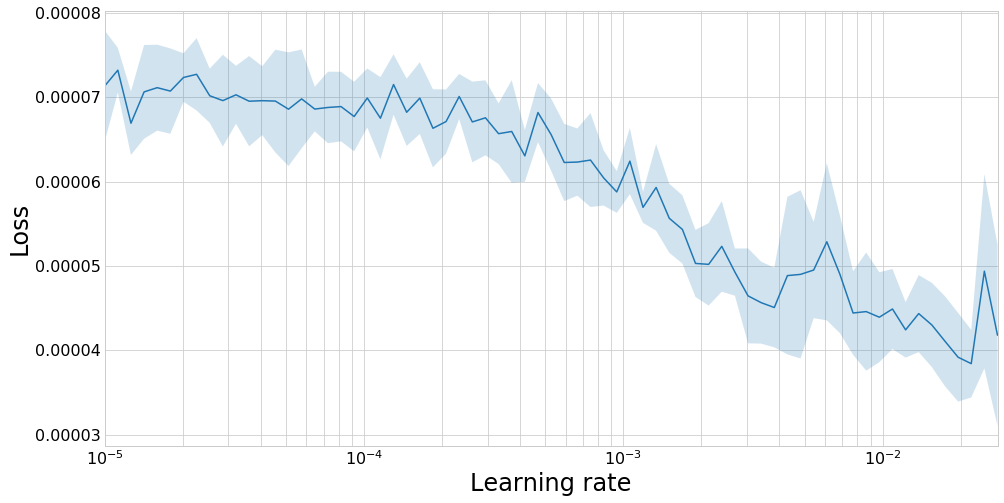

______________________________________



In [7]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [8]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105968). Check your callbacks.
  % delta_t_median)


1 New best found: 4.06695209378919e-05
2 New best found: 3.680352079681783e-05
3 New best found: 3.5785366954129576e-05
5 New best found: 3.473121743818774e-05
6 New best found: 3.4232568043962014e-05
7 New best found: 3.4145638027414456e-05
9 New best found: 3.402417467171167e-05
11 New best found: 3.3679015552083385e-05
12 New best found: 3.359102549937345e-05
13 New best found: 3.320267708401606e-05
14 New best found: 3.314799038358323e-05
15 New best found: 3.3082681620141134e-05
23 New best found: 3.304961636999941e-05
24 New best found: 3.2992060857337174e-05
26 New best found: 3.286300942904786e-05
27 New best found: 3.282533977946863e-05
28 New best found: 3.262172992256783e-05
29 New best found: 3.259690483632098e-05
30 New best found: 3.2589984517998046e-05
31 New best found: 3.257969954899028e-05
49 New best found: 3.237078982733963e-05
53 New best found: 3.234327702591393e-05
54 New best found: 3.227794641018596e-05
58 New best found: 3.2250425108570305e-05
59 New best foun

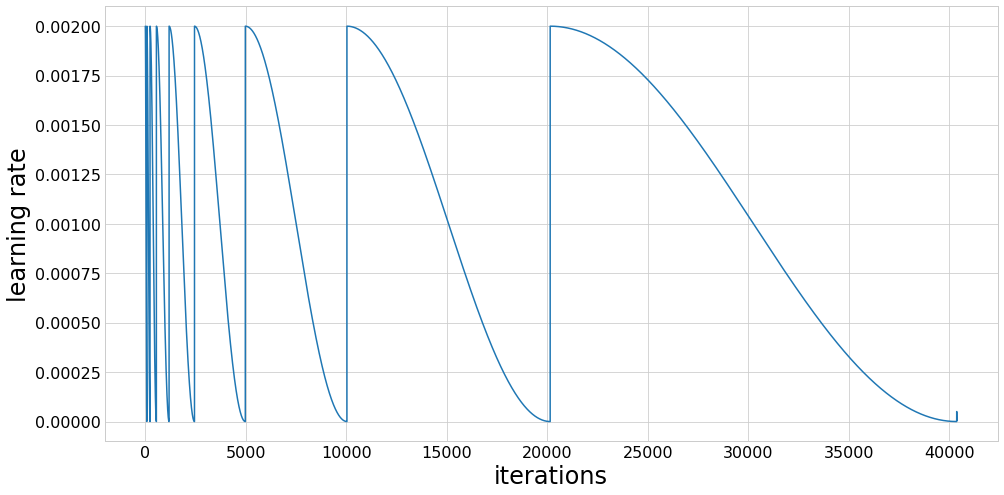

Fold took 569.942s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121633). Check your callbacks.
  % delta_t_median)


1 New best found: 4.051260776759591e-05
2 New best found: 3.7372193264309315e-05
3 New best found: 3.6171117662161125e-05
4 New best found: 3.5971097780566194e-05
5 New best found: 3.522837693308247e-05
6 New best found: 3.444564042438287e-05
7 New best found: 3.435123771778308e-05
9 New best found: 3.418259850004688e-05
11 New best found: 3.411797169683268e-05
12 New best found: 3.380728245974751e-05
13 New best found: 3.334934473532485e-05
14 New best found: 3.321205372194527e-05
15 New best found: 3.319507725536823e-05
22 New best found: 3.317742336366791e-05
24 New best found: 3.301970562606584e-05
25 New best found: 3.2924203285074326e-05
26 New best found: 3.278565278451424e-05
27 New best found: 3.26434700313257e-05
28 New best found: 3.260027092619566e-05
29 New best found: 3.257772464130539e-05
30 New best found: 3.2547632246860306e-05
49 New best found: 3.243820425559534e-05
50 New best found: 3.2411295676138255e-05
52 New best found: 3.236245503067039e-05
54 New best found: 

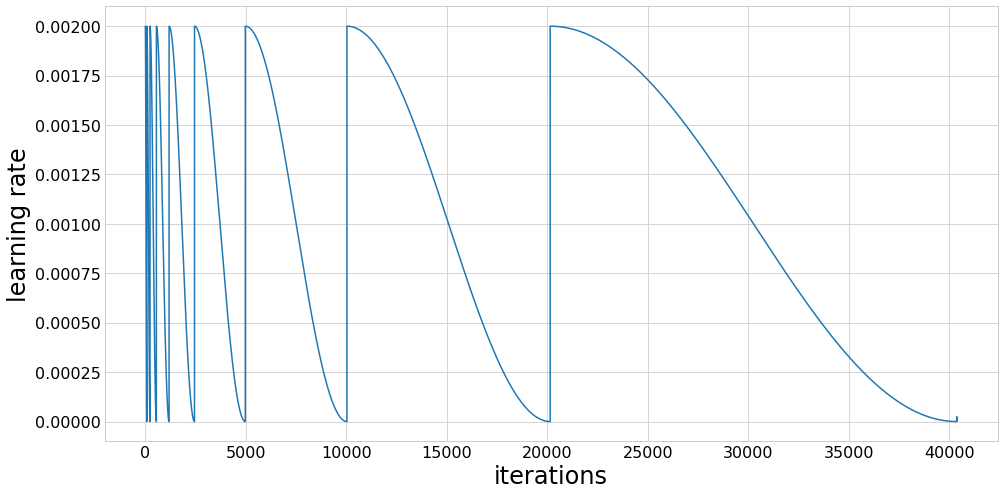

Fold took 572.259s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.275816). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138382). Check your callbacks.
  % delta_t_median)


1 New best found: 4.101726935225963e-05
2 New best found: 3.679709006348244e-05
3 New best found: 3.606718387645985e-05
4 New best found: 3.574840100675744e-05
5 New best found: 3.470218112050367e-05
6 New best found: 3.43423574771519e-05
7 New best found: 3.412650619558814e-05
11 New best found: 3.373875699333534e-05
12 New best found: 3.355848291285716e-05
13 New best found: 3.3291966907778565e-05
14 New best found: 3.31785834726507e-05
15 New best found: 3.3142899516560496e-05
24 New best found: 3.29987374351509e-05
26 New best found: 3.273384061951142e-05
28 New best found: 3.2619652331915536e-05
29 New best found: 3.258883758716651e-05
30 New best found: 3.256647973763153e-05
45 New best found: 3.245780279355966e-05
52 New best found: 3.232381329155797e-05
55 New best found: 3.227476775375312e-05
56 New best found: 3.217889783574444e-05
93 New best found: 3.2147619848175434e-05
97 New best found: 3.212664693737084e-05
98 New best found: 3.20846613287451e-05
101 New best found: 3.2

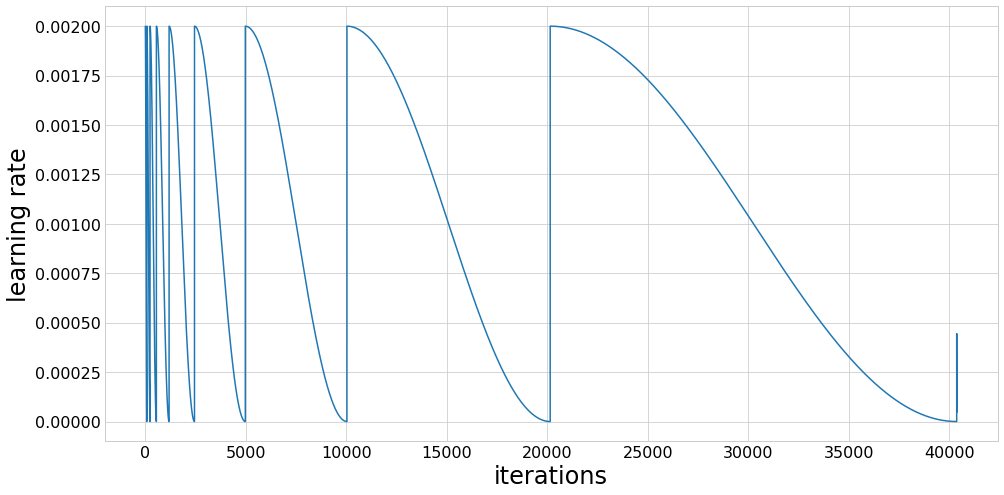

Fold took 580.960s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.302647). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151740). Check your callbacks.
  % delta_t_median)


1 New best found: 4.04228955070721e-05
2 New best found: 3.6119282692379784e-05
3 New best found: 3.5562262374151034e-05
4 New best found: 3.5204333379806485e-05
5 New best found: 3.4445083141326905e-05
6 New best found: 3.4077586585772223e-05
7 New best found: 3.389399598672753e-05
11 New best found: 3.3516349458659536e-05
12 New best found: 3.3196156687336044e-05
14 New best found: 3.300223723781528e-05
25 New best found: 3.2785825632163323e-05
26 New best found: 3.2620498578762636e-05
49 New best found: 3.249458339996636e-05
52 New best found: 3.243189148051897e-05
54 New best found: 3.233490612328751e-05
55 New best found: 3.2324714249989486e-05
56 New best found: 3.2279544936318414e-05
59 New best found: 3.226297592336778e-05
62 New best found: 3.2262367168732454e-05
63 New best found: 3.22618105870788e-05
96 New best found: 3.222376367339166e-05
97 New best found: 3.218035307509126e-05
99 New best found: 3.2160855138499756e-05
104 New best found: 3.216022442647955e-05
106 New bes

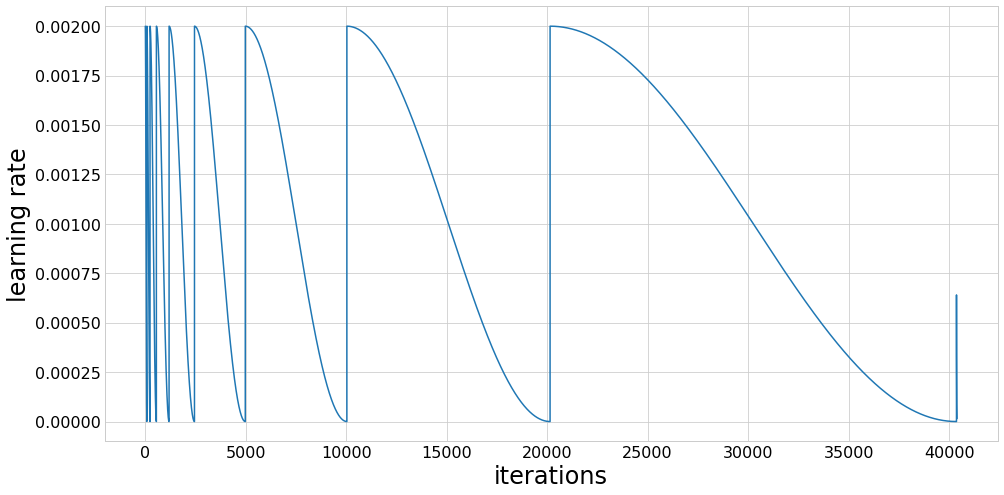

Fold took 605.709s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.366302). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183582). Check your callbacks.
  % delta_t_median)


1 New best found: 4.098318761516788e-05
2 New best found: 3.72030381578023e-05
3 New best found: 3.646376265103176e-05
4 New best found: 3.5850054543342286e-05
5 New best found: 3.5701515615981e-05
6 New best found: 3.483991542192975e-05
7 New best found: 3.4699123997265425e-05
11 New best found: 3.433745000863597e-05
12 New best found: 3.402389428222771e-05
13 New best found: 3.401315498493189e-05
14 New best found: 3.3964198870235765e-05
15 New best found: 3.392738007947185e-05
22 New best found: 3.3810784170948855e-05
24 New best found: 3.379177816632286e-05
25 New best found: 3.3432857316376196e-05
27 New best found: 3.339272848078291e-05
28 New best found: 3.331176058981736e-05
29 New best found: 3.330467798602035e-05
30 New best found: 3.326920276220863e-05
31 New best found: 3.3264074213030454e-05
49 New best found: 3.3105944776742465e-05
51 New best found: 3.302342191494134e-05
53 New best found: 3.289714263288054e-05
57 New best found: 3.28969134499468e-05
58 New best found: 3

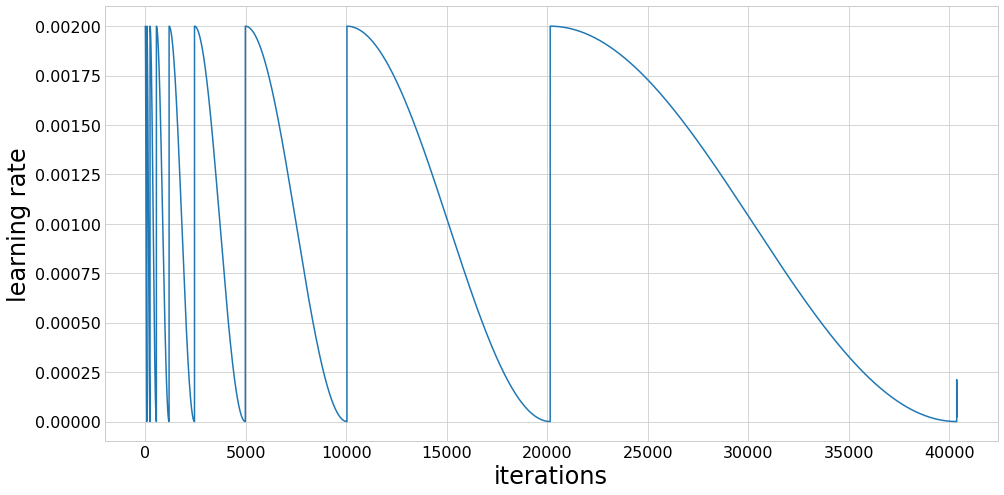

Fold took 597.396s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.364026). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182384). Check your callbacks.
  % delta_t_median)


1 New best found: 4.099120131484223e-05
2 New best found: 3.757966924161796e-05
3 New best found: 3.685163637780079e-05
4 New best found: 3.61591091837455e-05
5 New best found: 3.552920377966614e-05
7 New best found: 3.4919279124304435e-05
10 New best found: 3.451085543388972e-05
12 New best found: 3.4150200668831246e-05
13 New best found: 3.4031856966501e-05
14 New best found: 3.390701235410477e-05
20 New best found: 3.385812501573357e-05
22 New best found: 3.3850175692997405e-05
23 New best found: 3.373383690241445e-05
24 New best found: 3.348387827402324e-05
25 New best found: 3.3400397990864656e-05
26 New best found: 3.331042680794774e-05
28 New best found: 3.32752464415362e-05
29 New best found: 3.31519512585195e-05
52 New best found: 3.3143668421288735e-05
53 New best found: 3.300211459678665e-05
55 New best found: 3.293029005340851e-05
56 New best found: 3.289995316913233e-05
59 New best found: 3.287065167443286e-05
62 New best found: 3.287045503259293e-05
63 New best found: 3.2

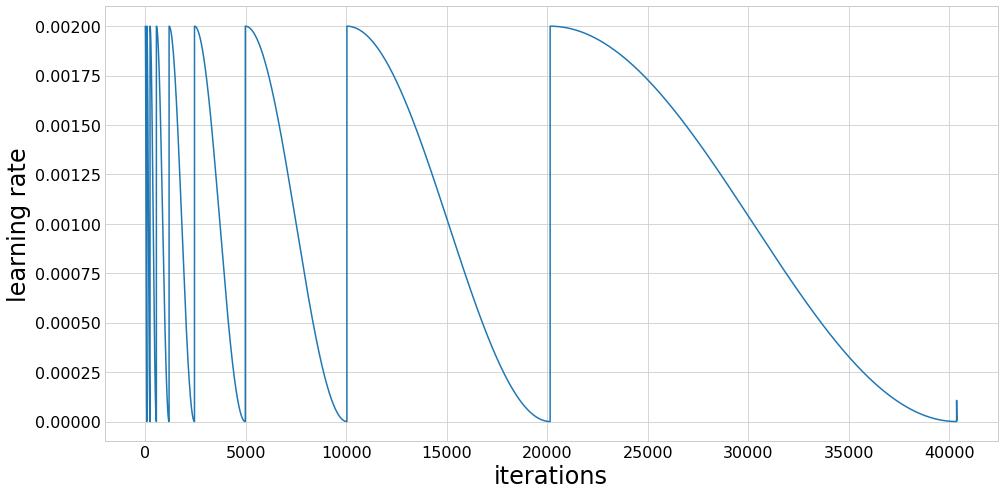

Fold took 607.234s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.382457). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191618). Check your callbacks.
  % delta_t_median)


1 New best found: 4.113067941943882e-05
2 New best found: 3.680620963132242e-05
3 New best found: 3.5456199829059184e-05
5 New best found: 3.451431990251876e-05
6 New best found: 3.3916950802813515e-05
7 New best found: 3.382232795120217e-05
11 New best found: 3.362382809282281e-05
12 New best found: 3.321954935527174e-05
13 New best found: 3.2938485544582366e-05
14 New best found: 3.282118624774739e-05
15 New best found: 3.2800786054576746e-05
23 New best found: 3.2687884403276254e-05
24 New best found: 3.259145205011009e-05
25 New best found: 3.2438546729827064e-05
26 New best found: 3.2296491040324325e-05
29 New best found: 3.22873682671343e-05
30 New best found: 3.225156159023754e-05
31 New best found: 3.2243988546542824e-05
48 New best found: 3.221561364480294e-05
52 New best found: 3.2198902542586436e-05
53 New best found: 3.2069496170151976e-05
54 New best found: 3.1997998114093206e-05
57 New best found: 3.1973344119614925e-05
58 New best found: 3.196740679704817e-05
59 New best

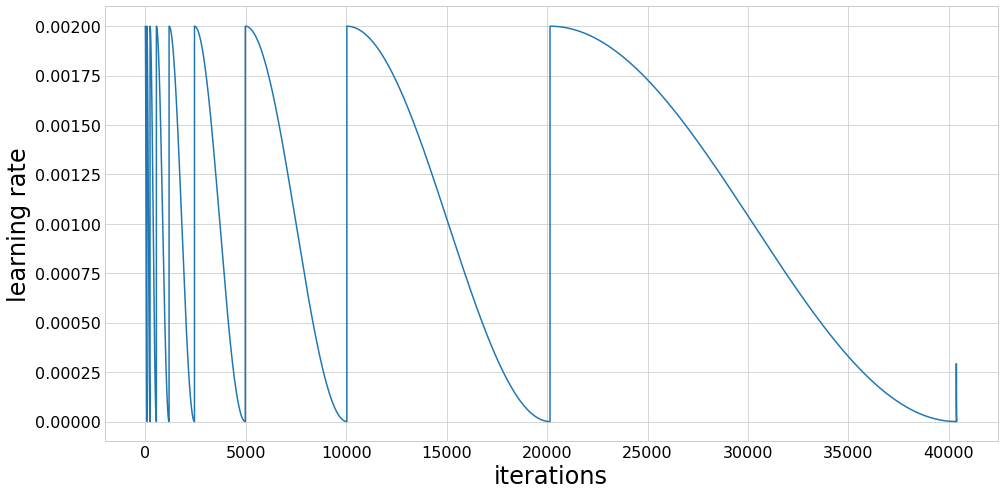

Fold took 631.382s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.422776). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211911). Check your callbacks.
  % delta_t_median)


1 New best found: 3.921162286930161e-05
2 New best found: 3.579423564125568e-05
3 New best found: 3.512128772437042e-05
4 New best found: 3.505835276457744e-05
5 New best found: 3.414382037569884e-05
6 New best found: 3.3874888438537157e-05
7 New best found: 3.3651249720894943e-05
12 New best found: 3.290141461338579e-05
14 New best found: 3.2697172707211714e-05
15 New best found: 3.266571905878367e-05
22 New best found: 3.2561144498367396e-05
23 New best found: 3.238017608583122e-05
25 New best found: 3.23795587066934e-05
26 New best found: 3.2208715141624176e-05
28 New best found: 3.2197245562196164e-05
29 New best found: 3.21354124101894e-05
30 New best found: 3.210401226964626e-05
48 New best found: 3.2047958727128705e-05
50 New best found: 3.195664311291181e-05
51 New best found: 3.1952515493973e-05
54 New best found: 3.187046407819419e-05
55 New best found: 3.18108248843532e-05
56 New best found: 3.1792089095944554e-05
57 New best found: 3.173728165157672e-05
58 New best found: 3

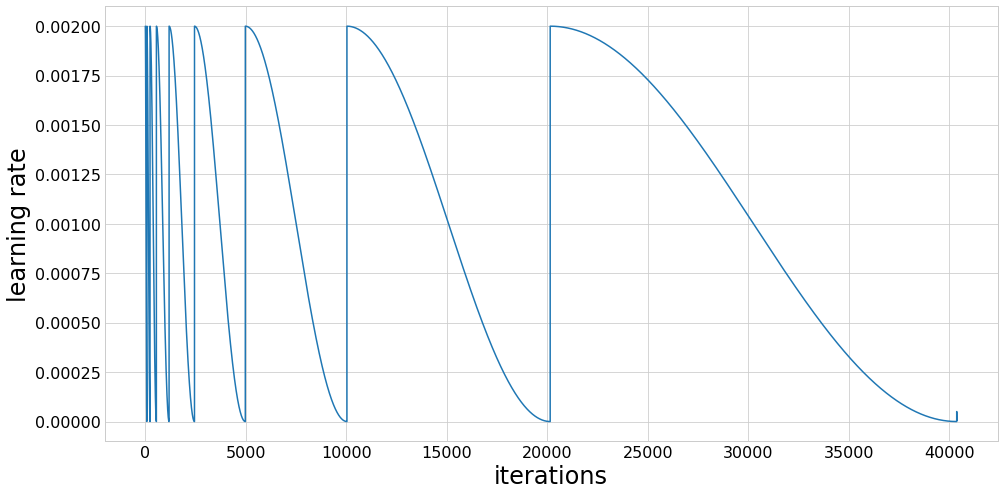

Fold took 615.617s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.461768). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231352). Check your callbacks.
  % delta_t_median)


1 New best found: 4.024315731076058e-05
2 New best found: 3.663142142322613e-05
3 New best found: 3.568295580043923e-05
5 New best found: 3.4418531401024666e-05
6 New best found: 3.406938964035362e-05
7 New best found: 3.3909404509176965e-05
11 New best found: 3.356864782690536e-05
12 New best found: 3.3503446566464845e-05
13 New best found: 3.304022900993005e-05
14 New best found: 3.2956755864142904e-05
15 New best found: 3.289948163292138e-05
24 New best found: 3.286447930149734e-05
25 New best found: 3.280552755022654e-05
26 New best found: 3.250346382410498e-05
28 New best found: 3.2464386463107074e-05
29 New best found: 3.24110697969445e-05
44 New best found: 3.232568240928231e-05
46 New best found: 3.230197045777459e-05
50 New best found: 3.211511341360165e-05
52 New best found: 3.2057717446878086e-05
53 New best found: 3.1980053482402584e-05
55 New best found: 3.194673645921284e-05
59 New best found: 3.1927989931136834e-05
60 New best found: 3.189730234298622e-05
61 New best fou

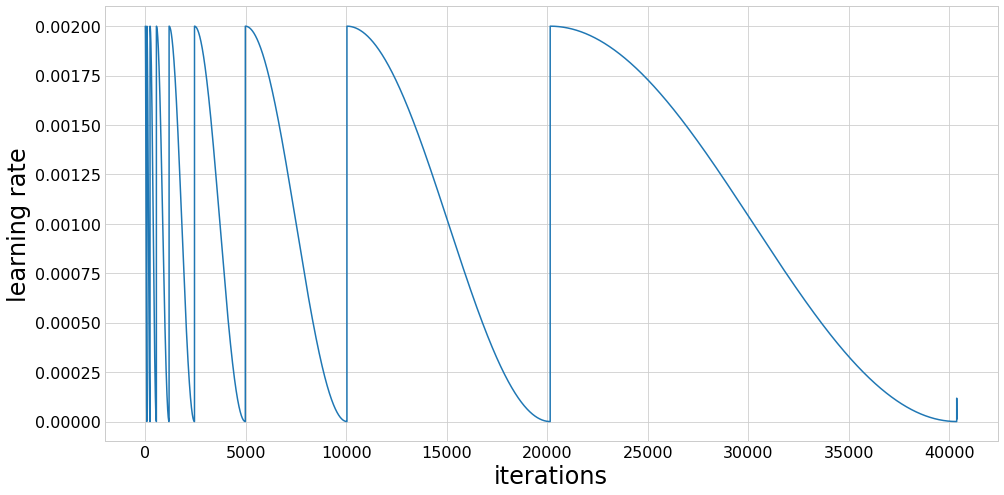

Fold took 619.732s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.512197). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256673). Check your callbacks.
  % delta_t_median)


1 New best found: 4.0101573203356986e-05
2 New best found: 3.6522575648387e-05
3 New best found: 3.596488453416609e-05
4 New best found: 3.56414868750676e-05
5 New best found: 3.489278068273443e-05
6 New best found: 3.437396091875248e-05
7 New best found: 3.420184663737333e-05
11 New best found: 3.387460058253177e-05
12 New best found: 3.361923747554653e-05
13 New best found: 3.328606594325481e-05
14 New best found: 3.316939246427413e-05
15 New best found: 3.314375805309135e-05
22 New best found: 3.314318104062002e-05
24 New best found: 3.282440399479433e-05
26 New best found: 3.277855217835448e-05
27 New best found: 3.275871684354936e-05
28 New best found: 3.262374513911355e-05
29 New best found: 3.261967237672582e-05
30 New best found: 3.2584760566948334e-05
31 New best found: 3.2577977669064084e-05
51 New best found: 3.254563724242787e-05
53 New best found: 3.2381818508655616e-05
55 New best found: 3.234933981963343e-05
56 New best found: 3.233099601275415e-05
57 New best found: 3.2

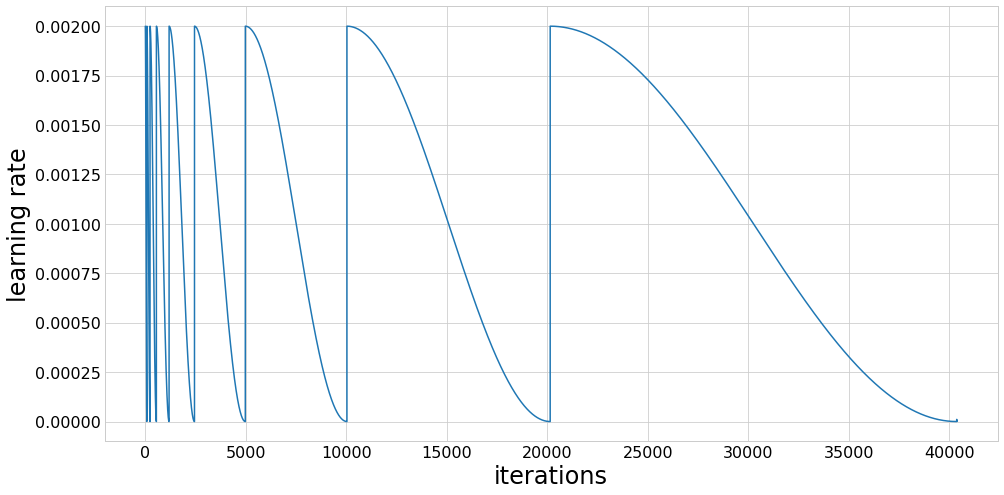

Fold took 627.809s


______________________________________
Training finished
Cross-validation took 6031.458s 


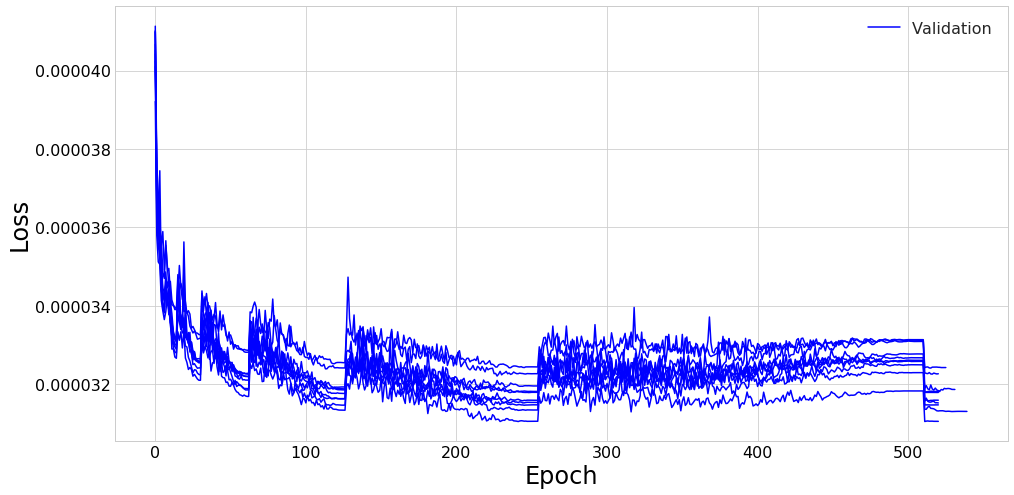

Mean loss = 3.17e-05 +- 1e-07
Mean wAUC = 0.0629 +- 0.0004
Mean AUC = 0.0977 +- 0.0003
Mean AMS = 3.89 +- 0.02
Mean cut = 0.959 +- 0.007
______________________________________



<Figure size 432x288 with 0 Axes>

In [9]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [5]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [6]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 7 with loss = 3.105257418712386e-05
Model 1 is 6 with loss = 3.130720845219912e-05
Model 2 is 1 with loss = 3.1468215155473445e-05
Model 3 is 2 with loss = 3.1526226651148265e-05
Model 4 is 8 with loss = 3.1579393091669774e-05
Model 5 is 9 with loss = 3.179049639959176e-05
Model 6 is 0 with loss = 3.180009502819426e-05
Model 7 is 3 with loss = 3.183279804943595e-05
Model 8 is 4 with loss = 3.2211644241015496e-05
Model 9 is 5 with loss = 3.24158981309247e-05


## Response on validation data without TTA

In [8]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [9]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0007007268004119396s per sample

Predicting fold 2 out of 10
Prediction took 0.00025274371430277827s per sample

Predicting fold 3 out of 10
Prediction took 0.0002466723211109638s per sample

Predicting fold 4 out of 10
Prediction took 0.000247852286696434s per sample

Predicting fold 5 out of 10
Prediction took 0.00023795838877558708s per sample

Predicting fold 6 out of 10
Prediction took 0.00023629347681999207s per sample

Predicting fold 7 out of 10
Prediction took 0.0002446395389735699s per sample

Predicting fold 8 out of 10
Prediction took 0.0002359157018363476s per sample

Predicting fold 9 out of 10
Prediction took 0.00024234104603528976s per sample

Predicting fold 10 out of 10
Prediction took 0.000237762201577425s per sample



In [9]:
val_df = convert_to_df(val_fy.source)

50000 candidates loaded


In [10]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

Testing ROC AUC: unweighted 0.9039358082529161, weighted 0.936188106326588


Best cut at 0.9601606558393072 corresponds to AMS of 3.8509197094388687
Maximum AMS for data is 3.9363282185678448 at cut of 0.9625431299209595
CPU times: user 207 ms, sys: 6.05 ms, total: 214 ms
Wall time: 212 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


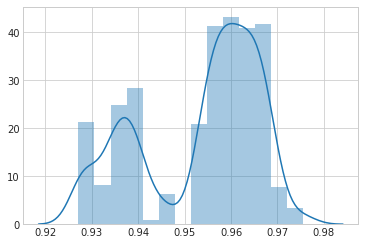

In [13]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.95335877 corresponds to AMS of 3.7513088858949497
Maximum AMS for data is 3.9363282185678448 at cut of 0.9625431299209595
CPU times: user 96 ms, sys: 5.07 ms, total: 101 ms
Wall time: 99.3 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


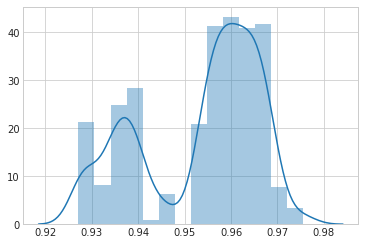

In [14]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

## Response on validation data with TTA

In [51]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"),
                           input_pipe=None, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32


In [53]:
fold_ensemble_predict(ensemble, weights, val_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.008464269859343768s per sample

Predicting fold 2 out of 10
Prediction took 0.008483699806034565s per sample

Predicting fold 3 out of 10
Prediction took 0.008477372918277978s per sample

Predicting fold 4 out of 10
Prediction took 0.008453153321892023s per sample

Predicting fold 5 out of 10
Prediction took 0.00847163368538022s per sample

Predicting fold 6 out of 10
Prediction took 0.008447725643217564s per sample

Predicting fold 7 out of 10
Prediction took 0.008486637408286334s per sample

Predicting fold 8 out of 10
Prediction took 0.008457921481877566s per sample

Predicting fold 9 out of 10
Prediction took 0.008485792864859103s per sample

Predicting fold 10 out of 10
Prediction took 0.008487020641565323s per sample



In [15]:
val_df_tta = convert_to_df(val_fy.source, pred_name='pred_TTA')

50000 candidates loaded


In [16]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class),
                                                           roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class, sample_weight=val_df_tta.gen_weight)))

Testing ROC AUC: unweighted 0.9040282719338125, weighted 0.9362725210967513


Best cut at 0.9596911527373053 corresponds to AMS of 3.898619660763579
Maximum AMS for data is 3.942877244425158 at cut of 0.9623900055885315
CPU times: user 26.1 s, sys: 13.7 ms, total: 26.1 s
Wall time: 26.1 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


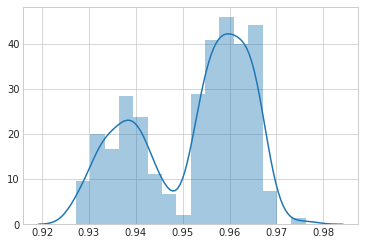

In [17]:
%%time
cut_kde_tta = kde_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.9520467 corresponds to AMS of 3.753240414021513
Maximum AMS for data is 3.942877244425158 at cut of 0.9623900055885315
CPU times: user 104 ms, sys: 7.13 ms, total: 112 ms
Wall time: 110 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


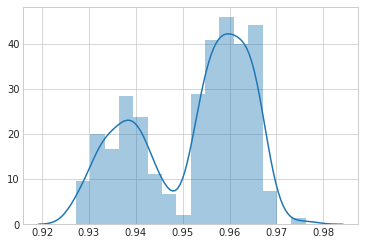

In [18]:
%%time
cut_mean_tta = mean_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [19]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [58]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.00024642170809886674s per sample

Predicting fold 2 out of 10
Prediction took 0.00025089867772026494s per sample

Predicting fold 3 out of 10
Prediction took 0.000246919429844076s per sample

Predicting fold 4 out of 10
Prediction took 0.0002455576253208247s per sample

Predicting fold 5 out of 10
Prediction took 0.0002455917957154187s per sample

Predicting fold 6 out of 10
Prediction took 0.00024345511441881007s per sample

Predicting fold 7 out of 10
Prediction took 0.00024028229428963227s per sample

Predicting fold 8 out of 10
Prediction took 0.00024333328713070263s per sample

Predicting fold 9 out of 10
Prediction took 0.0002474763301963156s per sample

Predicting fold 10 out of 10
Prediction took 0.0002452863708138466s per sample

CPU times: user 2min 29s, sys: 15.4 s, total: 2min 45s
Wall time: 2min 15s


In [20]:
score_test_data(test_fy.source, cut_kde)

Public:Private AMS: 3.760081631171906 : 3.8163920237165727


(3.760081631171906, 3.8163920237165727)

In [21]:
score_test_data(test_fy.source, cut_mean)

Public:Private AMS: 3.7968388029692326 : 3.834594628937943


(3.7968388029692326, 3.834594628937943)

# Test scoring - With TTA

In [60]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"),
                            input_pipe=None, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32


In [61]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.008043612090362744s per sample

Predicting fold 2 out of 10
Prediction took 0.008091518349742347s per sample

Predicting fold 3 out of 10
Prediction took 0.008023184503750367s per sample

Predicting fold 4 out of 10
Prediction took 0.008057139288227667s per sample

Predicting fold 5 out of 10
Prediction took 0.008026755189963363s per sample

Predicting fold 6 out of 10
Prediction took 0.008023722195015712s per sample

Predicting fold 7 out of 10
Prediction took 0.008016828335279768s per sample

Predicting fold 8 out of 10
Prediction took 0.008056638800623742s per sample

Predicting fold 9 out of 10
Prediction took 0.008015387136082758s per sample

Predicting fold 10 out of 10
Prediction took 0.008013743815435605s per sample

CPU times: user 1h 23min 40s, sys: 9min 22s, total: 1h 33min 2s
Wall time: 1h 13min 40s


In [22]:
score_test_data(test_fy.source, cut_kde_tta, pred_name='pred_TTA')

Public:Private AMS: 3.7880215466294107 : 3.8104793943511877


(3.7880215466294107, 3.8104793943511877)

In [23]:
score_test_data(test_fy.source, cut_mean_tta, pred_name='pred_TTA')

Public:Private AMS: 3.805384981184887 : 3.8303749970818095


(3.805384981184887, 3.8303749970818095)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)